This Kernel for someone want to deep dive into image classification. I use CNN for classification model. If you found this Kernel helpful please up vote it. If you have some feedback and question don't forget to comment below. 

I have simplier model with 
* https://www.kaggle.com/uysimty/get-start-image-classification

# Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../dogs-vs-cats"))


Using TensorFlow backend.


['.ipynb_checkpoints', 'dogs-vs-cats', 'keras-cnn-dog-or-cat-classification.ipynb', 'sampleSubmission.csv']


# Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [3]:
filenames = os.listdir("../dogs-vs-cats/dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head(10)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
5,cat.10000.jpg,0
6,cat.10001.jpg,0
7,cat.10002.jpg,0
8,cat.10003.jpg,0
9,cat.10004.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


### See Total In count

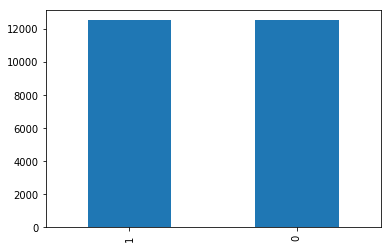

In [6]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

cat.1446.jpg


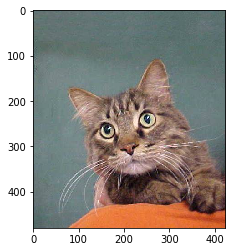

In [7]:
sample = random.choice(filenames)
print(sample)
image = load_img("../dogs-vs-cats/dogs-vs-cats/train/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2

# Callbacks

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [10]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

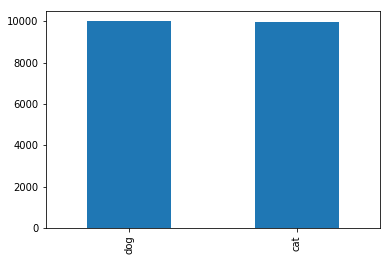

In [15]:
train_df['category'].value_counts().plot.bar()

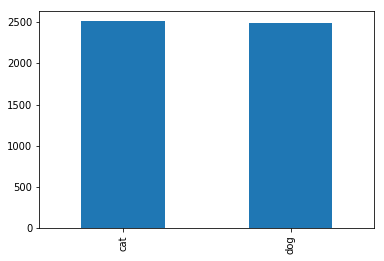

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255, 
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../dogs-vs-cats/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


### Validation Generator

In [25]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../dogs-vs-cats/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


# See how our generator work

In [29]:
example_df = train_df.sample(n=1).reset_index(drop=True)
print(example_df)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../dogs-vs-cats/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

       filename category
0  dog.9752.jpg      dog
Found 1 images belonging to 1 classes.


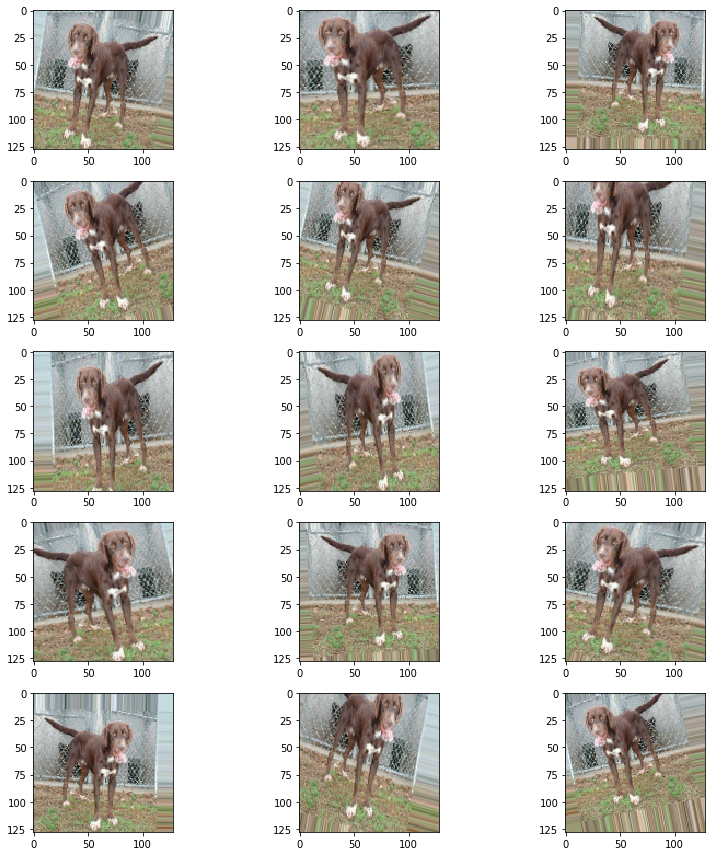

In [28]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [22]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1333/1333 [==============================] - 247s 186ms/step - loss: 0.7514 - acc: 0.6291 - val_loss: 0.6320 - val_acc: 0.6603
Epoch 2/50
1333/1333 [==============================] - 199s 149ms/step - loss: 0.5521 - acc: 0.7241 - val_loss: 0.4828 - val_acc: 0.7749
Epoch 3/50
1333/1333 [==============================] - 197s 148ms/step - loss: 0.5015 - acc: 0.7627 - val_loss: 0.4962 - val_acc: 0.7535
Epoch 4/50
1333/1333 [==============================] - 197s 148ms/step - loss: 0.4718 - acc: 0.7775 - val_loss: 0.3970 - val_acc: 0.8371
Epoch 5/50
1333/1333 [==============================] - 196s 147ms/step - loss: 0.4423 - acc: 0.8007 - val_loss: 0.4924 - val_acc: 0.7840
Epoch 6/50
1333/1333 [==============================] - 196s 147ms/step - loss: 0.4233 - acc: 0.8096 - val_loss: 0.4130 - val_acc: 0.8233

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
1333/1333 [=====================

# Save Model

In [23]:
model.save_weights("model.h5")

# Virtualize Training

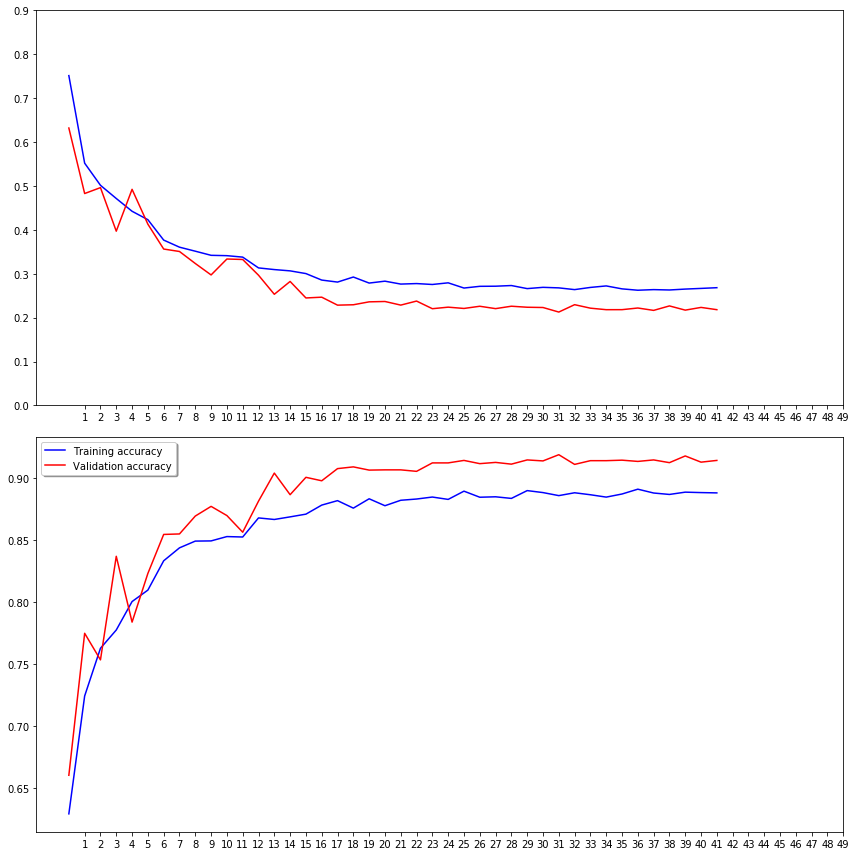

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [25]:
test_filenames = os.listdir("../input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


# Predict

In [27]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [29]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [30]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

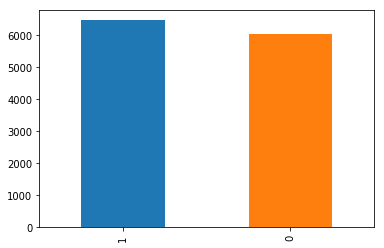

In [31]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

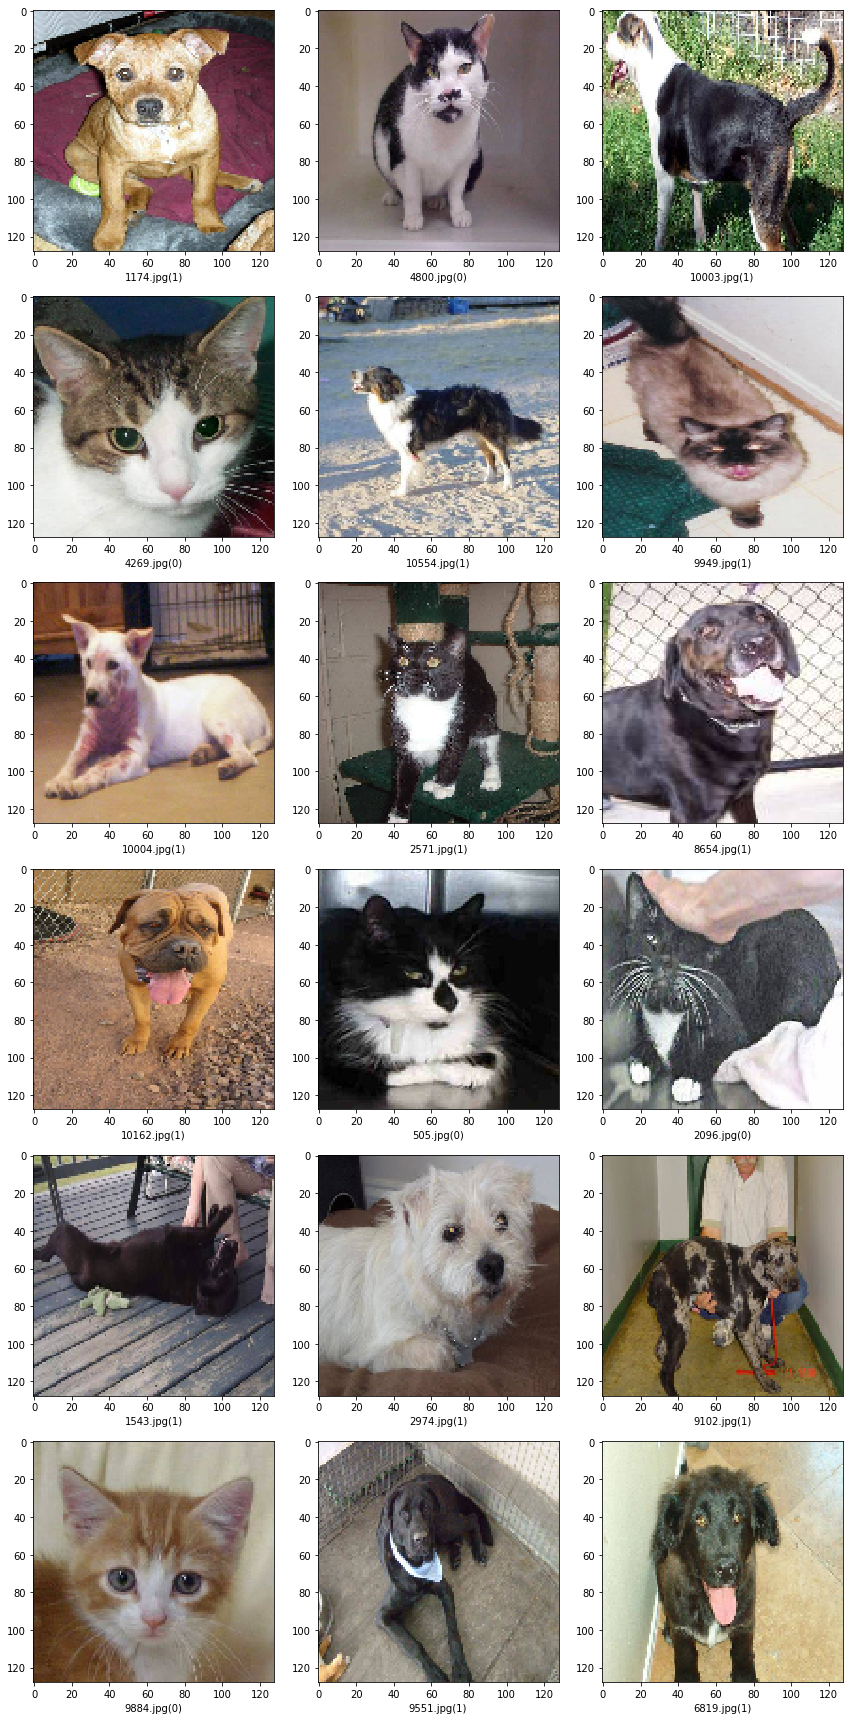

In [32]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [33]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)